### Evaluate all models

In [86]:
# import pandas as pd

# def calculate_metrics(true_file_path, detected_file_path):
#     """
#     Calculate TP, FP, FN, precision, recall, F1 score, and F5 score by matching on file_idx, entity_text, and positions.
    
#     Args:
#     true_file_path (str): Path to the CSV file containing the true entities (test set).
#     detected_file_path (str): Path to the CSV file containing the detected entities (output from Presidio).
    
#     Returns:
#     pd.DataFrame: A DataFrame containing the calculated metrics for each category and overall.
#     """
    
#     # Load the true entities and detected entities
#     df_true = pd.read_csv(true_file_path)
#     # df_true = df_true[df_true['file_idx'].isin([4,7,8,10,11])]
#     df_detected = pd.read_csv(detected_file_path)
    
#     # Mapping of Presidio-detected entity types to true entity types
#     entity_type_mapping = {
#         "PERSON": "NAME_STUDENT",
#         "EMAIL_ADDRESS": "EMAIL",
#         "URL": "URL_PERSONAL",
#         "PHONE_NUMBER": "PHONE_NUM"
#     }
    
#     # Apply the mapping to standardize the entity types in df_detected
#     df_detected['type'] = df_detected['type'].map(entity_type_mapping).fillna(df_detected['type'])
    
#     # Merge dataframes to find true positives (TP)
#     df_merged = pd.merge(df_detected, df_true, on=['file_idx', 'entity_text', 'positions'], suffixes=('_detected', '_true'))
    
#     # Create a list to store metrics for each category
#     metrics_list = []
    
#     # Calculate metrics for each category
#     for entity_type in df_true['type'].unique():
#         # Filter for the current entity type
#         df_true_type = df_true[df_true['type'] == entity_type]
#         df_detected_type = df_detected[df_detected['type'] == entity_type]
        
#         # Merge to find true positives for this type
#         df_merged_type = pd.merge(df_detected_type, df_true_type, on=['file_idx', 'entity_text', 'positions'], suffixes=('_detected', '_true'))
        
#         # Calculate TP, FP, FN for this type
#         TP_type = len(df_merged_type)
#         FP_type = len(df_detected_type) - TP_type
#         FN_type = len(df_true_type) - TP_type
        
#         # Calculate precision, recall, F1 score, F5 score for this type
#         precision_type = round(TP_type / (TP_type + FP_type), 4) if (TP_type + FP_type) > 0 else 0
#         recall_type = round(TP_type / (TP_type + FN_type), 4) if (TP_type + FN_type) > 0 else 0
#         F1_type = round(2 * (precision_type * recall_type) / (precision_type + recall_type), 4) if (precision_type + recall_type) > 0 else 0
#         F5_type = round((1 + 5**2) * (precision_type * recall_type) / ((5**2 * precision_type) + recall_type), 4) if ((5**2 * precision_type) + recall_type) > 0 else 0
        
#         # Store the metrics for this type in the list
#         metrics_list.append({
#             'Entity Type': entity_type,
#             'TP': TP_type,
#             'FP': FP_type,
#             'FN': FN_type,
#             'Precision': precision_type,
#             'Recall': recall_type,
#             'F1 Score': F1_type,
#             'F5 Score': F5_type
#         })
    
#     # Calculate overall metrics after per-category metrics
#     TP = len(df_merged)
#     FP = len(df_detected) - TP
#     FN = len(df_true) - TP
    
#     # Calculate precision, recall, F1 score, F5 score for overall metrics
#     precision = round(TP / (TP + FP), 4) if (TP + FP) > 0 else 0
#     recall = round(TP / (TP + FN), 4) if (TP + FN) > 0 else 0
#     F1 = round(2 * (precision * recall) / (precision + recall), 4) if (precision + recall) > 0 else 0
#     F5 = round((1 + 5**2) * (precision * recall) / ((5**2 * precision) + recall), 4) if ((5**2 * precision) + recall) > 0 else 0
    
#     # Append the overall metrics as the last row
#     metrics_list.append({
#         'Entity Type': 'Overall',
#         'TP': TP,
#         'FP': FP,
#         'FN': FN,
#         'Precision': precision,
#         'Recall': recall,
#         'F1 Score': F1,
#         'F5 Score': F5
#     })
    
#     # Convert the metrics list to a DataFrame
#     metrics_df = pd.DataFrame(metrics_list)
    
#     return metrics_df


In [33]:
import pandas as pd

def calculate_metrics(gold_csv, pred_csv):
    """
    Computes precision, recall, F1 score, and F5 score for each type and overall between two CSV files.

    Parameters:
    - gold_csv: Path to the gold standard CSV file.
    - pred_csv: Path to the predicted annotations CSV file.
    - epsilon: Allowed difference in start positions when matching entities.

    Returns:
    - A pandas DataFrame with precision, recall, F1 score, and F5 score for each type and overall.
    """
    # Read CSV files
    gold_df = pd.read_csv(gold_csv)
    pred_df = pd.read_csv(pred_csv)

    # Mapping of Presidio-detected entity types to true entity types
    entity_type_mapping = {
        "PERSON": "NAME_STUDENT",
        "EMAIL_ADDRESS": "EMAIL",
        "URL": "URL_PERSONAL",
        "PHONE_NUMBER": "PHONE_NUM"
    }
    
    # Apply the mapping to standardize the entity types in pred_df
    pred_df['type'] = pred_df['type'].map(entity_type_mapping).fillna(pred_df['type'])

    # Define the types
    types = ['NAME_STUDENT', 'URL_PERSONAL', 'EMAIL', 'PHONE_NUM']

    # Initialize counts for each type and overall
    counts = {}
    for entity_type in types + ['Overall']:
        counts[entity_type] = {'TP': 0, 'FP': 0, 'FN': 0}

    # Function to parse positions and extract start index
    def extract_start_position(position_str):
        # Remove parentheses and split by comma
        position_str = position_str.strip('()')
        start_str, end_str = position_str.split(',')
        start = int(start_str.strip())
        end = int(end_str.strip())
        return start  # Return start index

    # Parse positions in gold_df and pred_df
    gold_df['start_position'] = gold_df['positions'].apply(extract_start_position)
    pred_df['start_position'] = pred_df['positions'].apply(extract_start_position)

    # Compute counts for each type
    for entity_type in types:
        # Filter entities by type
        gold_entities = gold_df[gold_df['type'] == entity_type]
        pred_entities = pred_df[pred_df['type'] == entity_type]

        # Initialize matched indices
        matched_gold_indices = set()
        matched_pred_indices = set()

        # Group by file_idx for efficient matching
        gold_grouped = gold_entities.groupby('file_idx')
        pred_grouped = pred_entities.groupby('file_idx')

        # Get all file indices present in either gold or pred
        all_file_indices = set(gold_entities['file_idx']).union(set(pred_entities['file_idx']))

        for file_idx in all_file_indices:
            gold_file_entities = gold_grouped.get_group(file_idx) if file_idx in gold_grouped.groups else pd.DataFrame()
            pred_file_entities = pred_grouped.get_group(file_idx) if file_idx in pred_grouped.groups else pd.DataFrame()

            # Reset indices to ensure unique identification
            gold_file_entities = gold_file_entities.reset_index()
            pred_file_entities = pred_file_entities.reset_index()

            # Create lists of gold and pred entities for this file_idx
            gold_list = gold_file_entities.to_dict('records')
            pred_list = pred_file_entities.to_dict('records')

            # Match predicted entities to gold entities
            for pred_entity in pred_list:
                pred_start = pred_entity['start_position']
                pred_text = pred_entity['entity_text']
                pred_type = pred_entity['type']
                pred_global_idx = pred_entity['index']  # Unique index in pred_df

                matched = False
                for gold_entity in gold_list:
                    gold_start = gold_entity['start_position']
                    gold_text = gold_entity['entity_text']
                    gold_type = gold_entity['type']
                    gold_global_idx = gold_entity['index']  # Unique index in gold_df

                    # Check if this gold entity has already been matched
                    if gold_global_idx in matched_gold_indices:
                        continue

                    # Check for matching criteria
                    # Nearest Neighbor Search
                    # if (pred_text == gold_text and
                    #     abs(pred_start - gold_start) <= epsilon):
                    if (pred_text == gold_text):
                        # Match found
                        matched_gold_indices.add(gold_global_idx)
                        matched_pred_indices.add(pred_global_idx)
                        matched = True
                        break  # Move to next predicted entity

                # No match found for this predicted entity
                if not matched:
                    matched_pred_indices.add(pred_global_idx)  # Still add to matched_pred_indices as FP

        # Compute counts
        TP = len(matched_gold_indices)
        FP = len(pred_entities) - TP
        FN = len(gold_entities) - TP

        # Update counts
        counts[entity_type]['TP'] = TP
        counts[entity_type]['FP'] = FP
        counts[entity_type]['FN'] = FN

    # Compute overall counts
    for metric in ['TP', 'FP', 'FN']:
        counts['Overall'][metric] = sum(counts[entity_type][metric] for entity_type in types)

    # Prepare results
    results = []
    for entity_type in types + ['Overall']:
        TP = counts[entity_type]['TP']
        FP = counts[entity_type]['FP']
        FN = counts[entity_type]['FN']

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        F5 = (1 + 5**2) * (precision * recall) / ((5**2 * precision) + recall) if ((5**2 * precision) + recall) > 0 else 0

        results.append({
            'Entity Type': entity_type,
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'F1 Score': round(F1, 4),
            'F5 Score': round(F5, 4)
        })

    # Create DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df


In [34]:
import pandas as pd

def calculate_metrics_2(gold_csv, pred_csv, epsilon=100000000):
    """
    Computes precision, recall, F1 score, and F5 score for each type and overall between two CSV files.

    Parameters:
    - gold_csv: Path to the gold standard CSV file.
    - pred_csv: Path to the predicted annotations CSV file.
    - epsilon: Allowed difference in start positions when matching entities.

    Returns:
    - A pandas DataFrame with precision, recall, F1 score, and F5 score for each type and overall.
    """
    # Read CSV files
    gold_df = pd.read_csv(gold_csv)
    pred_df = pd.read_csv(pred_csv)

    # Mapping of Presidio-detected entity types to true entity types
    entity_type_mapping = {
        "PERSON": "NAME_STUDENT",
        "EMAIL_ADDRESS": "EMAIL",
        "URL": "URL_PERSONAL",
        "PHONE_NUMBER": "PHONE_NUM"
    }
    
    # Apply the mapping to standardize the entity types in pred_df
    pred_df['type'] = pred_df['type'].map(entity_type_mapping).fillna(pred_df['type'])

    # Define the types
    types = ['NAME_STUDENT', 'URL_PERSONAL', 'EMAIL', 'PHONE_NUM']

    # Initialize counts for each type and overall
    counts = {}
    for entity_type in types + ['Overall']:
        counts[entity_type] = {'TP': 0, 'FP': 0, 'FN': 0}

    # Function to parse positions and extract start index
    def extract_start_position(position_str):
        # Remove parentheses and split by comma
        position_str = position_str.strip('()')
        start_str, end_str = position_str.split(',')
        start = int(start_str.strip())
        end = int(end_str.strip())
        return start  # Return start index

    # Parse positions in gold_df and pred_df
    gold_df['start_position'] = gold_df['positions'].apply(extract_start_position)
    pred_df['start_position'] = pred_df['positions'].apply(extract_start_position)

    # Compute counts for each type
    for entity_type in types:
        # Filter entities by type
        gold_entities = gold_df[gold_df['type'] == entity_type]
        pred_entities = pred_df[pred_df['type'] == entity_type]

        # Initialize matched indices
        matched_gold_indices = set()
        matched_pred_indices = set()

        # Group by file_idx for efficient matching
        gold_grouped = gold_entities.groupby('file_idx')
        pred_grouped = pred_entities.groupby('file_idx')

        # Get all file indices present in either gold or pred
        all_file_indices = set(gold_entities['file_idx']).union(set(pred_entities['file_idx']))

        for file_idx in all_file_indices:
            gold_file_entities = gold_grouped.get_group(file_idx) if file_idx in gold_grouped.groups else pd.DataFrame()
            pred_file_entities = pred_grouped.get_group(file_idx) if file_idx in pred_grouped.groups else pd.DataFrame()

            # Reset indices to ensure unique identification
            gold_file_entities = gold_file_entities.reset_index()
            pred_file_entities = pred_file_entities.reset_index()

            # Create lists of gold and pred entities for this file_idx
            gold_list = gold_file_entities.to_dict('records')
            pred_list = pred_file_entities.to_dict('records')

            # Match predicted entities to gold entities
            for pred_entity in pred_list:
                pred_start = pred_entity['start_position']
                pred_text = pred_entity['entity_text']
                pred_type = pred_entity['type']
                pred_global_idx = pred_entity['index']  # Unique index in pred_df

                matched = False
                for gold_entity in gold_list:
                    gold_start = gold_entity['start_position']
                    gold_text = gold_entity['entity_text']
                    gold_type = gold_entity['type']
                    gold_global_idx = gold_entity['index']  # Unique index in gold_df

                    # Check if this gold entity has already been matched
                    if gold_global_idx in matched_gold_indices:
                        continue

                    # Check for matching criteria
                    # Nearest Neighbor Search
                    if (pred_text == gold_text and
                        abs(pred_start - gold_start) <= epsilon):
                        # Match found
                        matched_gold_indices.add(gold_global_idx)
                        matched_pred_indices.add(pred_global_idx)
                        matched = True
                        break  # Move to next predicted entity

                # No match found for this predicted entity
                if not matched:
                    matched_pred_indices.add(pred_global_idx)  # Still add to matched_pred_indices as FP

        # Compute counts
        TP = len(matched_gold_indices)
        FP = len(pred_entities) - TP
        FN = len(gold_entities) - TP

        # Update counts
        counts[entity_type]['TP'] = TP
        counts[entity_type]['FP'] = FP
        counts[entity_type]['FN'] = FN

    # Compute overall counts
    for metric in ['TP', 'FP', 'FN']:
        counts['Overall'][metric] = sum(counts[entity_type][metric] for entity_type in types)

    # Prepare results
    results = []
    for entity_type in types + ['Overall']:
        TP = counts[entity_type]['TP']
        FP = counts[entity_type]['FP']
        FN = counts[entity_type]['FN']

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        F5 = (1 + 5**2) * (precision * recall) / ((5**2 * precision) + recall) if ((5**2 * precision) + recall) > 0 else 0

        results.append({
            'Entity Type': entity_type,
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'F1 Score': round(F1, 4),
            'F5 Score': round(F5, 4)
        })

    # Create DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df


In [44]:
import matplotlib.pyplot as plt
import numpy as np

def plot_precision_recall_epsilon_together(true_file_path, detected_file_path, epsilon_range):
    epsilons = np.arange(0, epsilon_range + 1)  # Generate epsilon values from 0 to epsilon_range
    precisions = []
    recalls = []
    
    # Loop over each epsilon, calculate metrics and extract precision and recall for "Overall"
    for epsilon in epsilons:
        print(f"Processing shifting characters = {epsilon}")
        metrics_df = calculate_metrics_2(true_file_path, detected_file_path, epsilon=epsilon)
        overall_metrics = metrics_df[metrics_df['Entity Type'] == 'Overall']
        precisions.append(overall_metrics['Precision'].values[0])
        recalls.append(overall_metrics['Recall'].values[0])
    
    # Plot precision and recall against epsilon
    plt.figure(figsize=(8, 6))
    plt.plot(epsilons, precisions, label='Precision')
    plt.plot(epsilons, recalls, label='Recall')
    plt.xlabel('Number of Shifting Characters')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs. Number of Shifting Characters')
    
    # Set y-axis to start from 0
    plt.ylim(0, 1)
    
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_precision_recall_epsilon_split(true_file_path, detected_file_path, epsilon_range):
    epsilons = np.arange(0, epsilon_range + 1)  # Generate epsilon values from 0 to epsilon_range
    precisions = []
    recalls = []
    
    # Loop over each epsilon, calculate metrics and extract precision and recall for "Overall"
    for epsilon in epsilons:
        print(f"Processing shifting characters = {epsilon}")
        metrics_df = calculate_metrics_2(true_file_path, detected_file_path, epsilon=epsilon)
        overall_metrics = metrics_df[metrics_df['Entity Type'] == 'Overall']
        precisions.append(overall_metrics['Precision'].values[0])
        recalls.append(overall_metrics['Recall'].values[0])
    
    # Create subplots for Precision and Recall
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot Precision on the first subplot
    axs[0].plot(epsilons, precisions, label='Precision', color='b', linewidth = 1.5)
    axs[0].set_xlabel('Number of Shifting Characters')
    axs[0].set_ylabel('Precision')
    axs[0].set_title('Precision vs. Number of Shifting Characters')
    axs[0].grid(True)

    # Plot Recall on the second subplot
    axs[1].plot(epsilons, recalls, label='Recall', color='g', linewidth = 1.5)
    axs[1].set_xlabel('Number of Shifting Characters')
    axs[1].set_ylabel('Recall')
    axs[1].set_title('Recall vs. Number of Shifting Characters')
    axs[1].grid(True)

    # Display the plots side by side
    plt.tight_layout()
    plt.show()


In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming calculate_metrics_2 is already defined elsewhere

def plot_precision_recall_epsilon_split_methods(true_file_path, detected_file_path_lst):
    # Set epsilon ranges for each method
    epsilon_ranges = [200, 30]
    vertical_lines = [139, 12]

    # Define containers for storing precision and recall values for both methods
    method_precisions = []
    method_recalls = []

    # Loop over each detected_file_path in detected_file_path_lst
    for idx, detected_file_path in enumerate(detected_file_path_lst):
        epsilons = np.arange(0, epsilon_ranges[idx] + 1)  # Generate epsilon values for each method
        precisions = []
        recalls = []

        # Calculate metrics for each epsilon value
        for epsilon in epsilons:
            print(f"Processing shifting characters = {epsilon} for file: {detected_file_path}")
            metrics_df = calculate_metrics_2(true_file_path, detected_file_path, epsilon=epsilon)
            overall_metrics = metrics_df[metrics_df['Entity Type'] == 'Overall']
            precisions.append(overall_metrics['Precision'].values[0])
            recalls.append(overall_metrics['Recall'].values[0])
        
        method_precisions.append(precisions)
        method_recalls.append(recalls)

    # Create subplots for both methods
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Precision and Recall for Prompting Method (left plot)
    epsilons_prompting = np.arange(0, epsilon_ranges[0] + 1)
    axs[0].plot(epsilons_prompting, method_precisions[0], label='Precision')
    axs[0].plot(epsilons_prompting, method_recalls[0], label='Recall')
    axs[0].axvline(x=vertical_lines[0], color='red', linestyle='--', label=f'Vertical line at {vertical_lines[0]}')
    axs[0].set_xlabel('Number of Shifting Characters')
    axs[0].set_ylabel('Score')
    axs[0].set_title('Prompting Only Method')
    axs[0].set_ylim(0, 1)  # Set y-axis to start from 0
    axs[0].legend()
    axs[0].grid(True)

    # Plot Precision and Recall for Fine-tuned Method (right plot)
    epsilons_finetuned = np.arange(0, epsilon_ranges[1] + 1)
    axs[1].plot(epsilons_finetuned, method_precisions[1], label='Precision')
    axs[1].plot(epsilons_finetuned, method_recalls[1], label='Recall')
    axs[1].axvline(x=vertical_lines[1], color='red', linestyle='--', label=f'Vertical line at {vertical_lines[1]}')
    axs[1].set_xlabel('Number of Shifting Characters')
    axs[1].set_ylabel('Score')
    axs[1].set_title('Fine-tuned Only Method')
    axs[1].set_ylim(0, 1)  # Set y-axis to start from 0
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


### Evaluate the Presidio only model
#### (en_core_web_lg)

In [3]:
true_file_path = 'data/test_set.csv'
detected_file_path = 'output/pii_detected_lg_test.csv'

metrics_df_1_lg = calculate_metrics(true_file_path, detected_file_path)

print("Metrics DataFrame (Presidio only, en_core_web_lg):")
print(metrics_df_1_lg)

Metrics DataFrame (Presidio only, en_core_web_lg):
    Entity Type    TP     FP    FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2256  11496  1047     0.1640  0.6830    0.2646    0.6089
1  URL_PERSONAL   231   2862    45     0.0747  0.8370    0.1371    0.6010
2         EMAIL    81     14     1     0.8526  0.9878    0.9153    0.9818
3     PHONE_NUM    11     50     0     0.1803  1.0000    0.3056    0.8512
4       Overall  2579  14422  1093     0.1517  0.7023    0.2495    0.6163


#### (en_core_web_trf)

In [4]:
true_file_path = 'data/test_set.csv'
detected_file_path = 'output/pii_detected_trf_test.csv'

metrics_df_1_trf = calculate_metrics(true_file_path, detected_file_path)

print("Metrics DataFrame (Presidio only, en_core_web_trf):")
print(metrics_df_1_trf)

Metrics DataFrame (Presidio only, en_core_web_trf):
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2743  8467  560     0.2447  0.8305    0.3780    0.7604
1  URL_PERSONAL   230   601   46     0.2768  0.8333    0.4155    0.7735
2         EMAIL    81    14    1     0.8526  0.9878    0.9153    0.9818
3     PHONE_NUM    11    50    0     0.1803  1.0000    0.3056    0.8512
4       Overall  3065  9132  607     0.2513  0.8347    0.3863    0.7663


### Evaluate the Fine-tuned GPT-4o-mini only model

In [120]:
true_file_path = 'data/test_set.csv'
detected_file_path = 'output/pii_ft_detected.csv'

metrics_df_2_e0 = calculate_metrics(true_file_path, detected_file_path, epsilon=0)
metrics_df_2_e2 = calculate_metrics(true_file_path, detected_file_path, epsilon=2)
metrics_df_2_e10 = calculate_metrics(true_file_path, detected_file_path, epsilon=10)

print("Metrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 0):")
print(metrics_df_2_e0)
print("\nMetrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 2):")
print(metrics_df_2_e2)
print("\nMetrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 10):")
print(metrics_df_2_e10)

Metrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 0):
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  3102  2078  201     0.5988  0.9391    0.7313    0.9191
1  URL_PERSONAL   240   266   36     0.4743  0.8696    0.6138    0.8426
2         EMAIL    78    16    4     0.8298  0.9512    0.8864    0.9459
3     PHONE_NUM     8     7    3     0.5333  0.7273    0.6154    0.7172
4       Overall  3428  2367  244     0.5915  0.9336    0.7242    0.9132

Metrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 2):
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  3155  2025  148     0.6091  0.9552    0.7438    0.9348
1  URL_PERSONAL   252   254   24     0.4980  0.9130    0.6445    0.8847
2         EMAIL    78    16    4     0.8298  0.9512    0.8864    0.9459
3     PHONE_NUM     8     7    3     0.5333  0.7273    0.6154    0.7172
4       Overall  3493  2302  179     0.6028  0.9513    0.7379    0.9306

Metrics Da

### Evaluate the Prompting GPT-4o-mini only model

In [118]:
true_file_path = 'data/test_set.csv'
detected_file_path = 'output/pii_pt_detected.csv'

metrics_df_3_e0 = calculate_metrics(true_file_path, detected_file_path, epsilon = 0)
metrics_df_3_e2 = calculate_metrics(true_file_path, detected_file_path, epsilon = 2)
metrics_df_3_e10 = calculate_metrics(true_file_path, detected_file_path, epsilon = 10)

print("Metrics DataFrame (Prompting GPT-4o-mini only, epsilon = 0):")
print(metrics_df_3_e0)
print("\nMetrics DataFrame (Prompting GPT-4o-mini only, epsilon = 2):")
print(metrics_df_3_e2)
print("\nMetrics DataFrame (Prompting GPT-4o-mini only, epsilon = 10):")
print(metrics_df_3_e10)

Metrics DataFrame (Prompting GPT-4o-mini only, epsilon = 0):
    Entity Type    TP    FP    FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2252  1275  1051     0.6385  0.6818    0.6594    0.6800
1  URL_PERSONAL   164   434   112     0.2742  0.5942    0.3753    0.5687
2         EMAIL    52    90    30     0.3662  0.6341    0.4643    0.6168
3     PHONE_NUM     4    73     7     0.0519  0.3636    0.0909    0.2955
4       Overall  2472  1872  1200     0.5691  0.6732    0.6168    0.6685

Metrics DataFrame (Prompting GPT-4o-mini only, epsilon = 2):
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2438  1089  865     0.6912  0.7381    0.7139    0.7362
1  URL_PERSONAL   193   405   83     0.3227  0.6993    0.4416    0.6692
2         EMAIL    61    81   21     0.4296  0.7439    0.5446    0.7235
3     PHONE_NUM     4    73    7     0.0519  0.3636    0.0909    0.2955
4       Overall  2696  1648  976     0.6206  0.7342    0.6727    0.7291

Metric

Processing epsilon=0
Processing epsilon=1
Processing epsilon=2
Processing epsilon=3
Processing epsilon=4
Processing epsilon=5
Processing epsilon=6
Processing epsilon=7
Processing epsilon=8
Processing epsilon=9
Processing epsilon=10
Processing epsilon=11
Processing epsilon=12
Processing epsilon=13
Processing epsilon=14
Processing epsilon=15


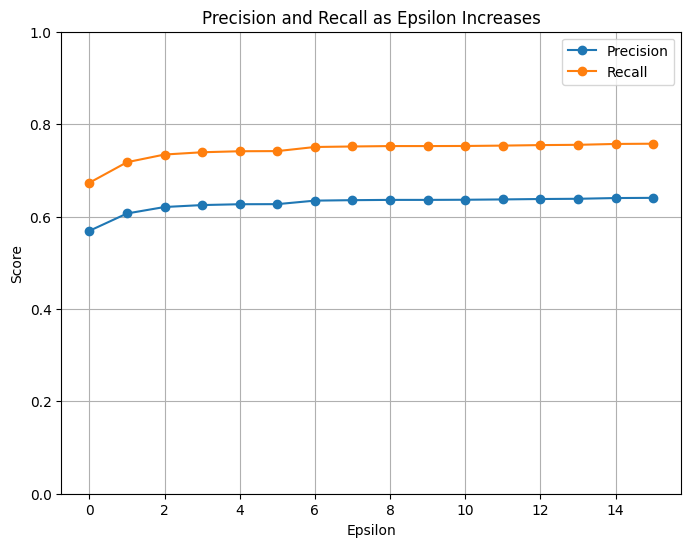

In [53]:
true_file_path = 'data/test_set.csv'
detected_file_path = 'output/pii_pt_detected.csv'
plot_precision_recall_epsilon_together(true_file_path, detected_file_path, 15)
# plot_precision_recall_epsilon_split(true_file_path, detected_file_path, 60)

Processing epsilon=0
Processing epsilon=1
Processing epsilon=2
Processing epsilon=3
Processing epsilon=4
Processing epsilon=5
Processing epsilon=6
Processing epsilon=7
Processing epsilon=8
Processing epsilon=9
Processing epsilon=10
Processing epsilon=11
Processing epsilon=12
Processing epsilon=13
Processing epsilon=14
Processing epsilon=15
Processing epsilon=16
Processing epsilon=17
Processing epsilon=18
Processing epsilon=19
Processing epsilon=20
Processing epsilon=21
Processing epsilon=22
Processing epsilon=23
Processing epsilon=24
Processing epsilon=25
Processing epsilon=26
Processing epsilon=27
Processing epsilon=28
Processing epsilon=29
Processing epsilon=30
Processing epsilon=31
Processing epsilon=32
Processing epsilon=33
Processing epsilon=34
Processing epsilon=35
Processing epsilon=36
Processing epsilon=37
Processing epsilon=38
Processing epsilon=39
Processing epsilon=40
Processing epsilon=41
Processing epsilon=42
Processing epsilon=43
Processing epsilon=44
Processing epsilon=4

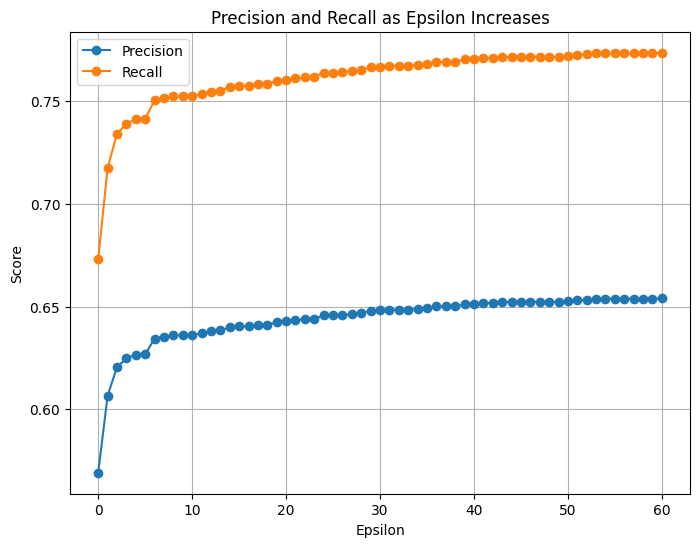

Processing epsilon=0
Processing epsilon=1
Processing epsilon=2
Processing epsilon=3
Processing epsilon=4
Processing epsilon=5
Processing epsilon=6
Processing epsilon=7
Processing epsilon=8
Processing epsilon=9
Processing epsilon=10
Processing epsilon=11
Processing epsilon=12
Processing epsilon=13
Processing epsilon=14
Processing epsilon=15
Processing epsilon=16
Processing epsilon=17
Processing epsilon=18
Processing epsilon=19
Processing epsilon=20
Processing epsilon=21
Processing epsilon=22
Processing epsilon=23
Processing epsilon=24
Processing epsilon=25
Processing epsilon=26
Processing epsilon=27
Processing epsilon=28
Processing epsilon=29
Processing epsilon=30
Processing epsilon=31
Processing epsilon=32
Processing epsilon=33
Processing epsilon=34
Processing epsilon=35
Processing epsilon=36
Processing epsilon=37
Processing epsilon=38
Processing epsilon=39
Processing epsilon=40
Processing epsilon=41
Processing epsilon=42
Processing epsilon=43
Processing epsilon=44
Processing epsilon=4

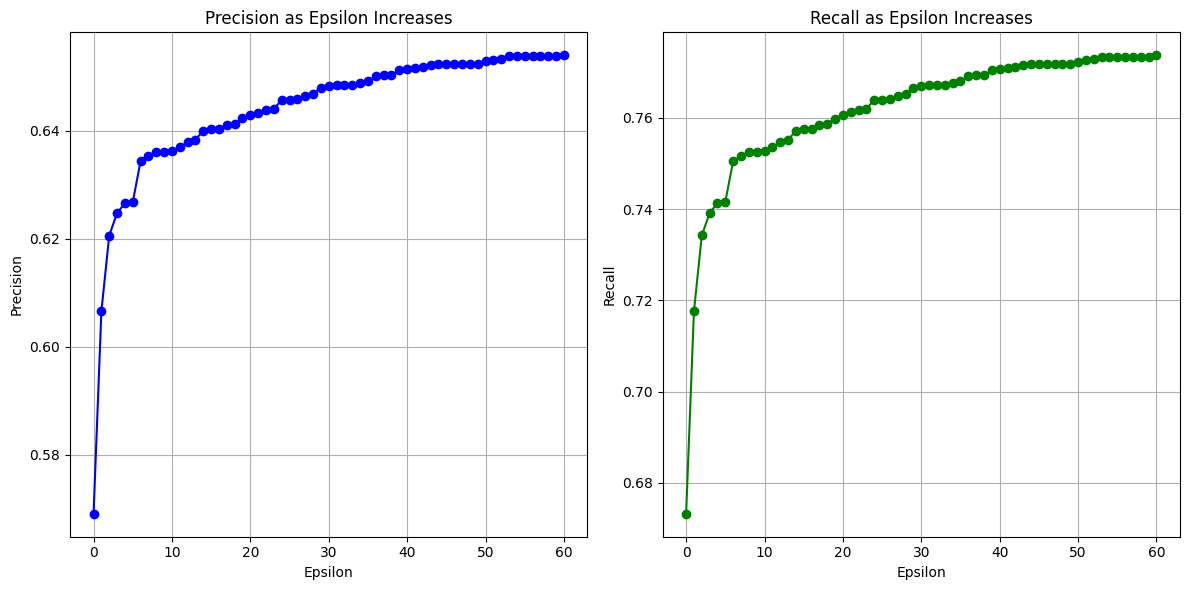

In [23]:
true_file_path = 'data/test_set.csv'
detected_file_path = 'output/pii_pt_detected.csv'
plot_precision_recall_epsilon_together(true_file_path, detected_file_path, 60)
plot_precision_recall_epsilon_split(true_file_path, detected_file_path, 60)

### Evaluate the Hybrid Presidio + Fine-tuned GPT-4o-mini model

In [131]:
true_file_path = 'data/test_set.csv'
detected_file_path = 'output/pii_pre+ft_detected.csv'

metrics_df_4 = calculate_metrics(true_file_path, detected_file_path)

print("Metrics DataFrame (Presidio + Fine-tuned GPT-4o-mini):")
print(metrics_df_4)

Metrics DataFrame (Presidio + Fine-tuned GPT-4o-mini):
    Entity Type    TP   FP    FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2383  441   920     0.8438  0.7215    0.7779    0.7255
1  URL_PERSONAL   187   59    89     0.7602  0.6775    0.7165    0.6804
2         EMAIL    81    5     1     0.9419  0.9878    0.9643    0.9860
3     PHONE_NUM     1    0    10     1.0000  0.0909    0.1667    0.0942
4       Overall  2652  505  1020     0.8400  0.7222    0.7767    0.7261


Testing Cost: $0.58 \
Testing runtime: 82m 57.3s

### Evaluate Experiements on diff context lengths + COT/NCOT

In [9]:
true_file_path = 'data/test_set.csv'
# detected_file_path = 'output/25_COT.csv'

for file in ['25_COT', '25_NCOT', '50_COT', '50_NCOT', '100_COT', '100_NCOT']:
    detected_file_path = f"output/{file}.csv"
    metrics_df = calculate_metrics(true_file_path, detected_file_path)

    print(f"Metrics DataFrame ({file}):")
    print(metrics_df)
    print()

Metrics DataFrame (25_COT):
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  3003  1563  300     0.6577  0.9092    0.7632    0.8960
1  URL_PERSONAL    21    15  255     0.5833  0.0761    0.1346    0.0787
2         EMAIL    78    13    4     0.8571  0.9512    0.9017    0.9472
3     PHONE_NUM     8     6    3     0.5714  0.7273    0.6400    0.7197
4       Overall  3110  1597  562     0.6607  0.8469    0.7423    0.8379

Metrics DataFrame (25_NCOT):
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2967  1586  336     0.6517  0.8983    0.7553    0.8854
1  URL_PERSONAL    12    10  264     0.5455  0.0435    0.0805    0.0451
2         EMAIL    78    14    4     0.8478  0.9512    0.8966    0.9468
3     PHONE_NUM     8     6    3     0.5714  0.7273    0.6400    0.7197
4       Overall  3065  1616  607     0.6548  0.8347    0.7339    0.8260

Metrics DataFrame (50_COT):
    Entity Type    TP    FP   FN  Precision  Reca

### Evaluate Hybrid: Fine-tune + Fine-tune as filtering results

In [23]:
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_ft_detected_ncot.csv'

metrics_df_5 = calculate_metrics(true_file_path, detected_file_path)

print("Metrics DataFrame (Hybrid: Fine-tune + Fine-tune, NCOT):")
print(metrics_df_5)

Metrics DataFrame (Hybrid: Fine-tune + Fine-tune, NCOT):
    Entity Type    TP   FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2094  282  516     0.8813  0.8023    0.8400    0.8051
1  URL_PERSONAL   159    4   51     0.9755  0.7571    0.8525    0.7637
2         EMAIL    59    9    2     0.8676  0.9672    0.9147    0.9630
3     PHONE_NUM     2    1    6     0.6667  0.2500    0.3636    0.2562
4       Overall  2314  296  575     0.8866  0.8010    0.8416    0.8040


Processing epsilon=0
Processing epsilon=1
Processing epsilon=2
Processing epsilon=3
Processing epsilon=4
Processing epsilon=5
Processing epsilon=6
Processing epsilon=7
Processing epsilon=8
Processing epsilon=9
Processing epsilon=10
Processing epsilon=11
Processing epsilon=12
Processing epsilon=13
Processing epsilon=14
Processing epsilon=15
Processing epsilon=16
Processing epsilon=17
Processing epsilon=18
Processing epsilon=19
Processing epsilon=20
Processing epsilon=21
Processing epsilon=22
Processing epsilon=23
Processing epsilon=24
Processing epsilon=25
Processing epsilon=26
Processing epsilon=27
Processing epsilon=28
Processing epsilon=29
Processing epsilon=30
Processing epsilon=31
Processing epsilon=32
Processing epsilon=33
Processing epsilon=34
Processing epsilon=35
Processing epsilon=36
Processing epsilon=37
Processing epsilon=38
Processing epsilon=39
Processing epsilon=40
Processing epsilon=41
Processing epsilon=42
Processing epsilon=43
Processing epsilon=44
Processing epsilon=4

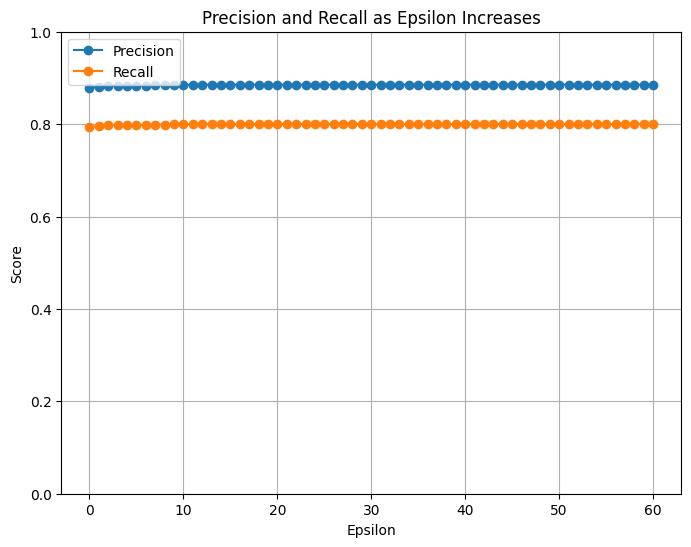

Processing epsilon=0
Processing epsilon=1
Processing epsilon=2
Processing epsilon=3
Processing epsilon=4
Processing epsilon=5
Processing epsilon=6
Processing epsilon=7
Processing epsilon=8
Processing epsilon=9
Processing epsilon=10
Processing epsilon=11
Processing epsilon=12
Processing epsilon=13
Processing epsilon=14
Processing epsilon=15
Processing epsilon=16
Processing epsilon=17
Processing epsilon=18
Processing epsilon=19
Processing epsilon=20
Processing epsilon=21
Processing epsilon=22
Processing epsilon=23
Processing epsilon=24
Processing epsilon=25
Processing epsilon=26
Processing epsilon=27
Processing epsilon=28
Processing epsilon=29
Processing epsilon=30
Processing epsilon=31
Processing epsilon=32
Processing epsilon=33
Processing epsilon=34
Processing epsilon=35
Processing epsilon=36
Processing epsilon=37
Processing epsilon=38
Processing epsilon=39
Processing epsilon=40
Processing epsilon=41
Processing epsilon=42
Processing epsilon=43
Processing epsilon=44
Processing epsilon=4

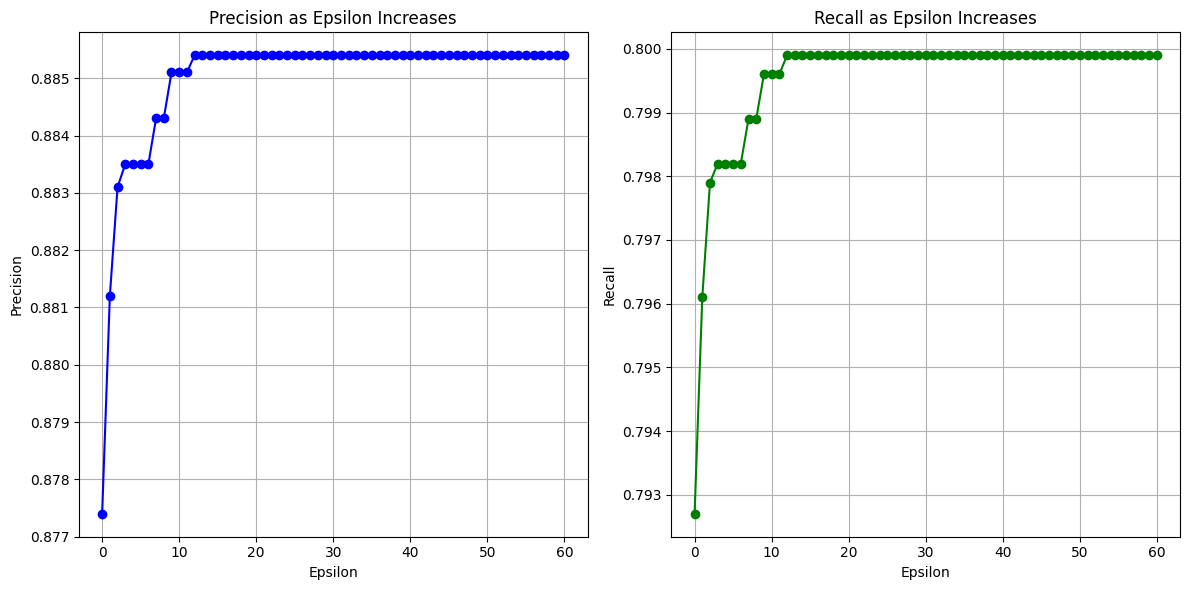

In [68]:
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_ft_detected_ncot.csv'
plot_precision_recall_epsilon_together(true_file_path, detected_file_path, 60)
plot_precision_recall_epsilon_split(true_file_path, detected_file_path, 60)

In [24]:
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_ft_detected_cot1.csv'

metrics_df_6 = calculate_metrics(true_file_path, detected_file_path)

print("Metrics DataFrame (Hybrid: Fine-tune + Fine-tune, COT1):")
print(metrics_df_6)

Metrics DataFrame (Hybrid: Fine-tune + Fine-tune, COT1):
    Entity Type    TP   FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2024  544  586     0.7882  0.7755    0.7818    0.7760
1  URL_PERSONAL    19    6  191     0.7600  0.0905    0.1617    0.0936
2         EMAIL    56    8    5     0.8750  0.9180    0.8960    0.9163
3     PHONE_NUM     4    3    4     0.5714  0.5000    0.5333    0.5024
4       Overall  2103  561  786     0.7894  0.7279    0.7574    0.7301


Processing epsilon=0
Processing epsilon=1
Processing epsilon=2
Processing epsilon=3
Processing epsilon=4
Processing epsilon=5
Processing epsilon=6
Processing epsilon=7
Processing epsilon=8
Processing epsilon=9
Processing epsilon=10
Processing epsilon=11
Processing epsilon=12
Processing epsilon=13
Processing epsilon=14
Processing epsilon=15
Processing epsilon=16
Processing epsilon=17
Processing epsilon=18
Processing epsilon=19
Processing epsilon=20


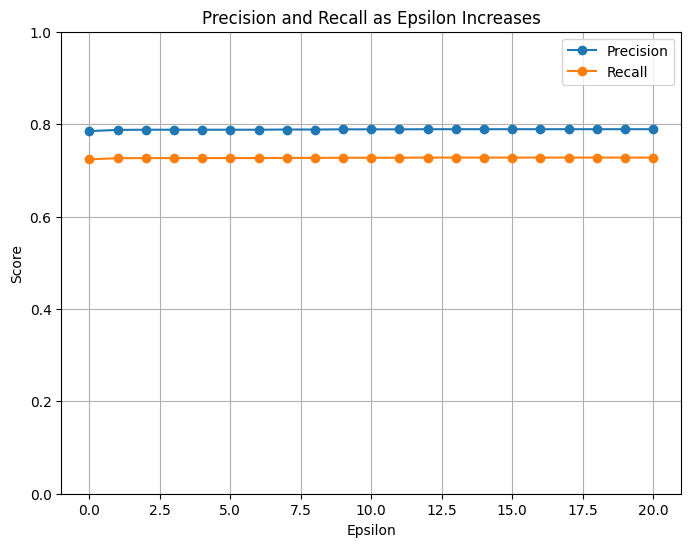

In [69]:
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_ft_detected_cot1.csv'
plot_precision_recall_epsilon_together(true_file_path, detected_file_path, 20)

Processing epsilon=0
Processing epsilon=1
Processing epsilon=2
Processing epsilon=3
Processing epsilon=4
Processing epsilon=5
Processing epsilon=6
Processing epsilon=7
Processing epsilon=8
Processing epsilon=9
Processing epsilon=10
Processing epsilon=11
Processing epsilon=12
Processing epsilon=13
Processing epsilon=14
Processing epsilon=15
Processing epsilon=16
Processing epsilon=17
Processing epsilon=18
Processing epsilon=19
Processing epsilon=20
Processing epsilon=21
Processing epsilon=22
Processing epsilon=23
Processing epsilon=24
Processing epsilon=25
Processing epsilon=26
Processing epsilon=27
Processing epsilon=28
Processing epsilon=29
Processing epsilon=30
Processing epsilon=31
Processing epsilon=32
Processing epsilon=33
Processing epsilon=34
Processing epsilon=35
Processing epsilon=36
Processing epsilon=37
Processing epsilon=38
Processing epsilon=39
Processing epsilon=40
Processing epsilon=41
Processing epsilon=42
Processing epsilon=43
Processing epsilon=44
Processing epsilon=4

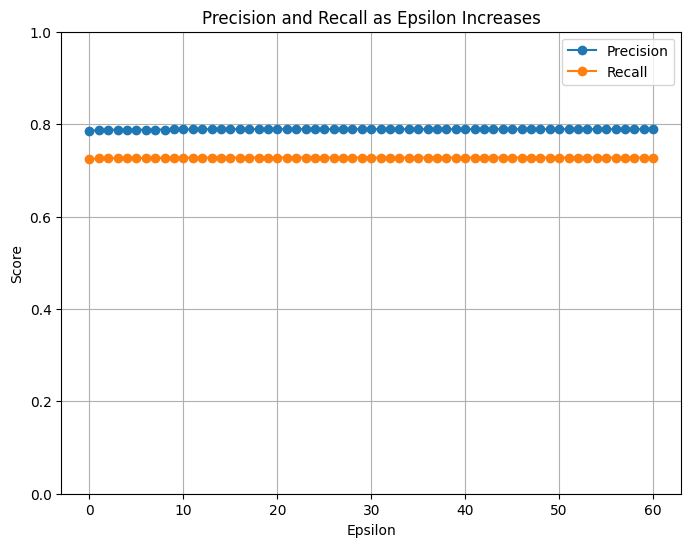

Processing epsilon=0
Processing epsilon=1
Processing epsilon=2
Processing epsilon=3
Processing epsilon=4
Processing epsilon=5
Processing epsilon=6
Processing epsilon=7
Processing epsilon=8
Processing epsilon=9
Processing epsilon=10
Processing epsilon=11
Processing epsilon=12
Processing epsilon=13
Processing epsilon=14
Processing epsilon=15
Processing epsilon=16
Processing epsilon=17
Processing epsilon=18
Processing epsilon=19
Processing epsilon=20
Processing epsilon=21
Processing epsilon=22
Processing epsilon=23
Processing epsilon=24
Processing epsilon=25
Processing epsilon=26
Processing epsilon=27
Processing epsilon=28
Processing epsilon=29
Processing epsilon=30
Processing epsilon=31
Processing epsilon=32
Processing epsilon=33
Processing epsilon=34
Processing epsilon=35
Processing epsilon=36
Processing epsilon=37
Processing epsilon=38
Processing epsilon=39
Processing epsilon=40
Processing epsilon=41
Processing epsilon=42
Processing epsilon=43
Processing epsilon=44
Processing epsilon=4

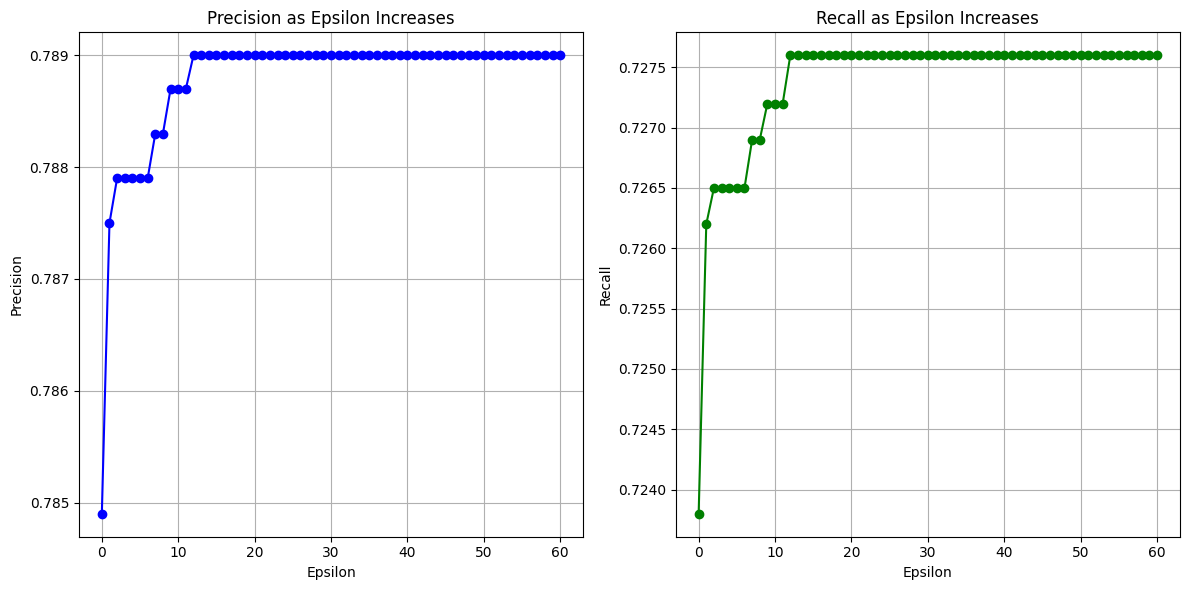

In [67]:
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_ft_detected_cot1.csv'
plot_precision_recall_epsilon_together(true_file_path, detected_file_path, 60)
plot_precision_recall_epsilon_split(true_file_path, detected_file_path, 60)

In [25]:
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_ft_detected_cot2.csv'

metrics_df_7 = calculate_metrics(true_file_path, detected_file_path)

print("Metrics DataFrame (Hybrid: Fine-tune + Fine-tune, COT2):")
print(metrics_df_7)

Metrics DataFrame (Hybrid: Fine-tune + Fine-tune, COT2):
    Entity Type    TP   FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2257  708  353     0.7612  0.8648    0.8097    0.8603
1  URL_PERSONAL   171   76   39     0.6923  0.8143    0.7484    0.8088
2         EMAIL    59   10    2     0.8551  0.9672    0.9077    0.9624
3     PHONE_NUM     7    4    1     0.6364  0.8750    0.7368    0.8626
4       Overall  2494  798  395     0.7576  0.8633    0.8070    0.8587


Processing epsilon=0
Processing epsilon=1
Processing epsilon=2
Processing epsilon=3
Processing epsilon=4
Processing epsilon=5
Processing epsilon=6
Processing epsilon=7
Processing epsilon=8
Processing epsilon=9
Processing epsilon=10
Processing epsilon=11
Processing epsilon=12
Processing epsilon=13
Processing epsilon=14
Processing epsilon=15
Processing epsilon=16
Processing epsilon=17
Processing epsilon=18
Processing epsilon=19
Processing epsilon=20
Processing epsilon=21
Processing epsilon=22
Processing epsilon=23
Processing epsilon=24
Processing epsilon=25
Processing epsilon=26
Processing epsilon=27
Processing epsilon=28
Processing epsilon=29
Processing epsilon=30
Processing epsilon=31
Processing epsilon=32
Processing epsilon=33
Processing epsilon=34
Processing epsilon=35
Processing epsilon=36
Processing epsilon=37
Processing epsilon=38
Processing epsilon=39
Processing epsilon=40
Processing epsilon=41
Processing epsilon=42
Processing epsilon=43
Processing epsilon=44
Processing epsilon=4

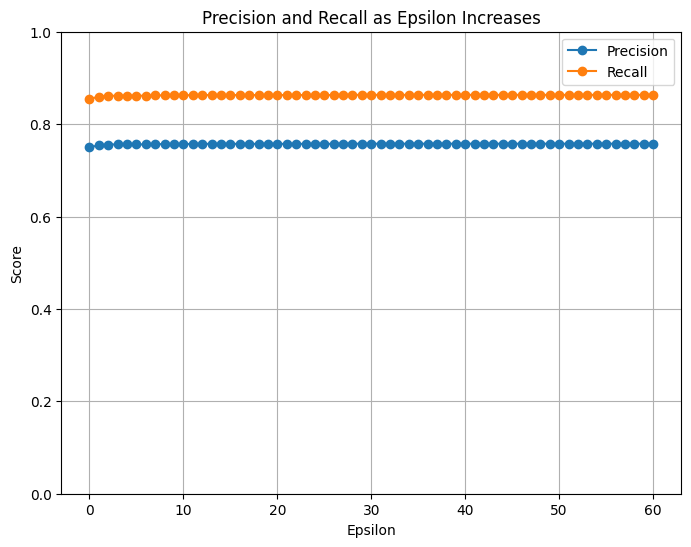

Processing epsilon=0
Processing epsilon=1
Processing epsilon=2
Processing epsilon=3
Processing epsilon=4
Processing epsilon=5
Processing epsilon=6
Processing epsilon=7
Processing epsilon=8
Processing epsilon=9
Processing epsilon=10
Processing epsilon=11
Processing epsilon=12
Processing epsilon=13
Processing epsilon=14
Processing epsilon=15
Processing epsilon=16
Processing epsilon=17
Processing epsilon=18
Processing epsilon=19
Processing epsilon=20
Processing epsilon=21
Processing epsilon=22
Processing epsilon=23
Processing epsilon=24
Processing epsilon=25
Processing epsilon=26
Processing epsilon=27
Processing epsilon=28
Processing epsilon=29
Processing epsilon=30
Processing epsilon=31
Processing epsilon=32
Processing epsilon=33
Processing epsilon=34
Processing epsilon=35
Processing epsilon=36
Processing epsilon=37
Processing epsilon=38
Processing epsilon=39
Processing epsilon=40
Processing epsilon=41
Processing epsilon=42
Processing epsilon=43
Processing epsilon=44
Processing epsilon=4

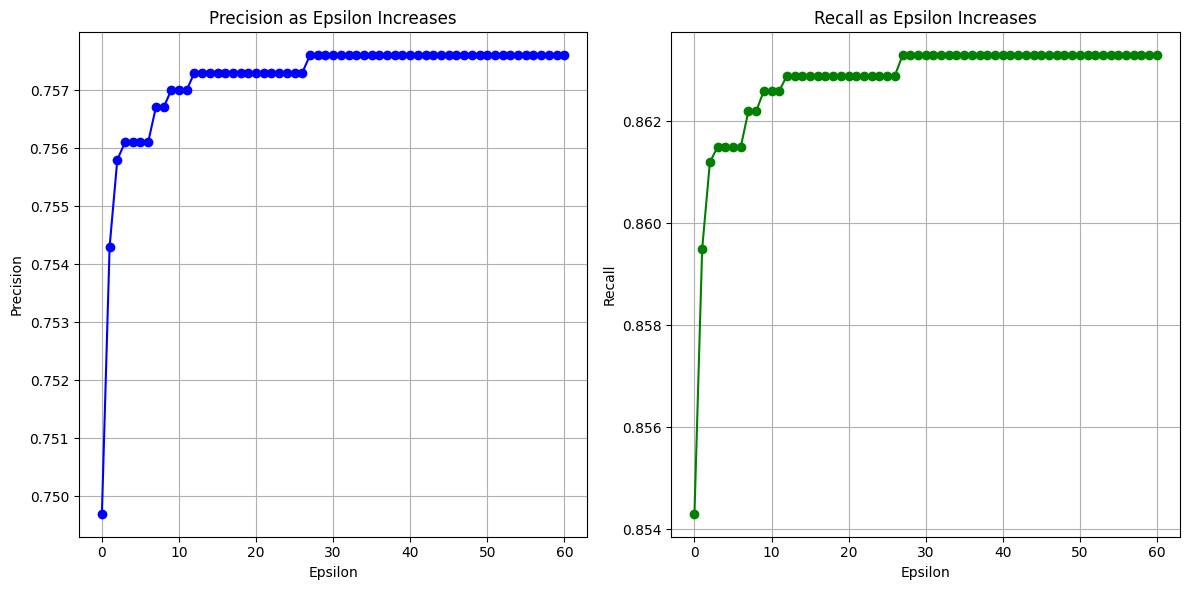

In [66]:
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_ft_detected_cot2.csv'
plot_precision_recall_epsilon_together(true_file_path, detected_file_path, 60)
plot_precision_recall_epsilon_split(true_file_path, detected_file_path, 60)

In [49]:
print("Metrics DataFrame (Hybrid: Fine-tune + Fine-tune, NCOT):")
print(metrics_df_5)
print('')
print("Metrics DataFrame (Hybrid: Fine-tune + Fine-tune, COT1):")
print(metrics_df_6)
print('')
print("Metrics DataFrame (Hybrid: Fine-tune + Fine-tune, COT2):")
print(metrics_df_7)

Metrics DataFrame (Hybrid: Fine-tune + Fine-tune, NCOT):
    Entity Type    TP   FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2090  286  520     0.8796  0.8008    0.8383    0.8035
1  URL_PERSONAL   159    4   51     0.9755  0.7571    0.8525    0.7637
2         EMAIL    59    9    2     0.8676  0.9672    0.9147    0.9630
3     PHONE_NUM     2    1    6     0.6667  0.2500    0.3636    0.2562
4       Overall  2310  300  579     0.8851  0.7996    0.8402    0.8026

Metrics DataFrame (Hybrid: Fine-tune + Fine-tune, COT1):
    Entity Type    TP   FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2022  546  588     0.7874  0.7747    0.7810    0.7752
1  URL_PERSONAL    19    6  191     0.7600  0.0905    0.1617    0.0936
2         EMAIL    56    8    5     0.8750  0.9180    0.8960    0.9163
3     PHONE_NUM     4    3    4     0.5714  0.5000    0.5333    0.5024
4       Overall  2101  563  788     0.7887  0.7272    0.7567    0.7294

Metrics DataFrame (Hybrid: Fine-

### Evaluation on 60% Test Dataset

In [58]:
# Presidio (lg)
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_pre_lg_detected_2.csv'

metrics_df = calculate_metrics(true_file_path, detected_file_path)

print("Metrics DataFrame (Presidio only, en_core_web_lg):")
print(metrics_df)

Metrics DataFrame (Presidio only, en_core_web_lg):
    Entity Type    TP     FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  1795   9304  815     0.1617  0.6877    0.2619    0.6113
1  URL_PERSONAL   179   2258   31     0.0735  0.8524    0.1352    0.6054
2         EMAIL    60     11    1     0.8451  0.9836    0.9091    0.9774
3     PHONE_NUM     8     37    0     0.1778  1.0000    0.3019    0.8490
4       Overall  2042  11610  847     0.1496  0.7068    0.2469    0.6182


In [57]:
# Presidio (trf)
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_pre_trf_detected_2.csv'

metrics_df = calculate_metrics(true_file_path, detected_file_path)

print("Metrics DataFrame (Presidio only, en_core_web_trf):")
print(metrics_df)

Metrics DataFrame (Presidio only, en_core_web_trf):
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2167  6854  443     0.2402  0.8303    0.3726    0.7586
1  URL_PERSONAL   178   478   32     0.2713  0.8476    0.4111    0.7836
2         EMAIL    60    11    1     0.8451  0.9836    0.9091    0.9774
3     PHONE_NUM     8    37    0     0.1778  1.0000    0.3019    0.8490
4       Overall  2413  7380  476     0.2464  0.8352    0.3805    0.7649


In [55]:
# Presidio (trf), with URL of all scores
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_detected_trf_2.csv'

metrics_df = calculate_metrics(true_file_path, detected_file_path)

print("Metrics DataFrame (Presidio only (w/ URL of all scores), en_core_web_trf):")
print(metrics_df)

# We can see that the precision for URL dramatically dropped.

Metrics DataFrame (Presidio only (w/ URL of all scores), en_core_web_trf):
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2168  6853  442     0.2403  0.8307    0.3728    0.7590
1  URL_PERSONAL   178  2259   32     0.0730  0.8476    0.1345    0.6021
2         EMAIL    60    11    1     0.8451  0.9836    0.9091    0.9774
3     PHONE_NUM     8    37    0     0.1778  1.0000    0.3019    0.8490
4       Overall  2414  9160  475     0.2086  0.8356    0.3338    0.7490


In [15]:
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_ft_detected_2.csv'

metrics_df = calculate_metrics(true_file_path, detected_file_path)
print(f"Metrics DataFrame (Fine-tuned GPT-4o-mini only, without epsilon): \n{metrics_df}\n")

metrics_df = calculate_metrics_2(true_file_path, detected_file_path)
print(f"Metrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 1goal): \n{metrics_df}")

Metrics DataFrame (Fine-tuned GPT-4o-mini only, without epsilon): 
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2503  1601  107     0.6099  0.9590    0.7456    0.9383
1  URL_PERSONAL   197   208   13     0.4864  0.9381    0.6407    0.9057
2         EMAIL    59    11    2     0.8429  0.9672    0.9008    0.9618
3     PHONE_NUM     7     5    1     0.5833  0.8750    0.7000    0.8585
4       Overall  2766  1825  123     0.6025  0.9574    0.7396    0.9362

Metrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 1goal): 
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2503  1601  107     0.6099  0.9590    0.7456    0.9383
1  URL_PERSONAL   197   208   13     0.4864  0.9381    0.6407    0.9057
2         EMAIL    59    11    2     0.8429  0.9672    0.9008    0.9618
3     PHONE_NUM     7     5    1     0.5833  0.8750    0.7000    0.8585
4       Overall  2766  1825  123     0.6025  0.9574    0.7396    0.9362


In [60]:
# Fine-tune only
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_ft_detected_2.csv'

metrics_df_0 = calculate_metrics(true_file_path, detected_file_path, epsilon=0)
metrics_df_2 = calculate_metrics(true_file_path, detected_file_path, epsilon=2)
metrics_df_10 = calculate_metrics(true_file_path, detected_file_path, epsilon=10)
metrics_df_15 = calculate_metrics(true_file_path, detected_file_path, epsilon=15)

print("Metrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 0):")
print(metrics_df_0)
print("\nMetrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 2):")
print(metrics_df_2)
print("\nMetrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 10):")
print(metrics_df_10)
print("\nMetrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 15):")
print(metrics_df_15)

Metrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 0):
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2473  1631  137     0.6026  0.9475    0.7367    0.9271
1  URL_PERSONAL   184   221   26     0.4543  0.8762    0.5984    0.8460
2         EMAIL    59    11    2     0.8429  0.9672    0.9008    0.9618
3     PHONE_NUM     7     5    1     0.5833  0.8750    0.7000    0.8585
4       Overall  2723  1868  166     0.5931  0.9425    0.7281    0.9217

Metrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 2):
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2498  1606  112     0.6087  0.9571    0.7441    0.9365
1  URL_PERSONAL   195   210   15     0.4815  0.9286    0.6341    0.8966
2         EMAIL    59    11    2     0.8429  0.9672    0.9008    0.9618
3     PHONE_NUM     7     5    1     0.5833  0.8750    0.7000    0.8585
4       Overall  2759  1832  130     0.6010  0.9550    0.7377    0.9338

Metrics Da

Processing shifting characters = 0
Processing shifting characters = 1
Processing shifting characters = 2
Processing shifting characters = 3
Processing shifting characters = 4
Processing shifting characters = 5
Processing shifting characters = 6
Processing shifting characters = 7
Processing shifting characters = 8
Processing shifting characters = 9
Processing shifting characters = 10
Processing shifting characters = 11
Processing shifting characters = 12
Processing shifting characters = 13
Processing shifting characters = 14
Processing shifting characters = 15
Processing shifting characters = 16
Processing shifting characters = 17
Processing shifting characters = 18
Processing shifting characters = 19
Processing shifting characters = 20
Processing shifting characters = 21
Processing shifting characters = 22
Processing shifting characters = 23
Processing shifting characters = 24
Processing shifting characters = 25
Processing shifting characters = 26
Processing shifting characters = 27
Pr

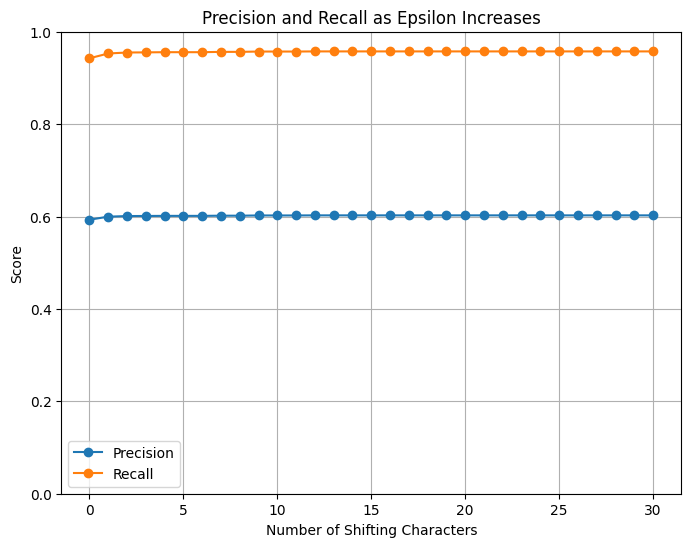

In [48]:
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_ft_detected_2.csv'
plot_precision_recall_epsilon_together(true_file_path, detected_file_path, 30)
# plot_precision_recall_epsilon_split(true_file_path, detected_file_path, 60)

Processing shifting characters = 0
Processing shifting characters = 1
Processing shifting characters = 2
Processing shifting characters = 3
Processing shifting characters = 4
Processing shifting characters = 5
Processing shifting characters = 6
Processing shifting characters = 7
Processing shifting characters = 8
Processing shifting characters = 9
Processing shifting characters = 10
Processing shifting characters = 11
Processing shifting characters = 12
Processing shifting characters = 13
Processing shifting characters = 14
Processing shifting characters = 15
Processing shifting characters = 16
Processing shifting characters = 17
Processing shifting characters = 18
Processing shifting characters = 19
Processing shifting characters = 20
Processing shifting characters = 21
Processing shifting characters = 22
Processing shifting characters = 23
Processing shifting characters = 24
Processing shifting characters = 25
Processing shifting characters = 26
Processing shifting characters = 27
Pr

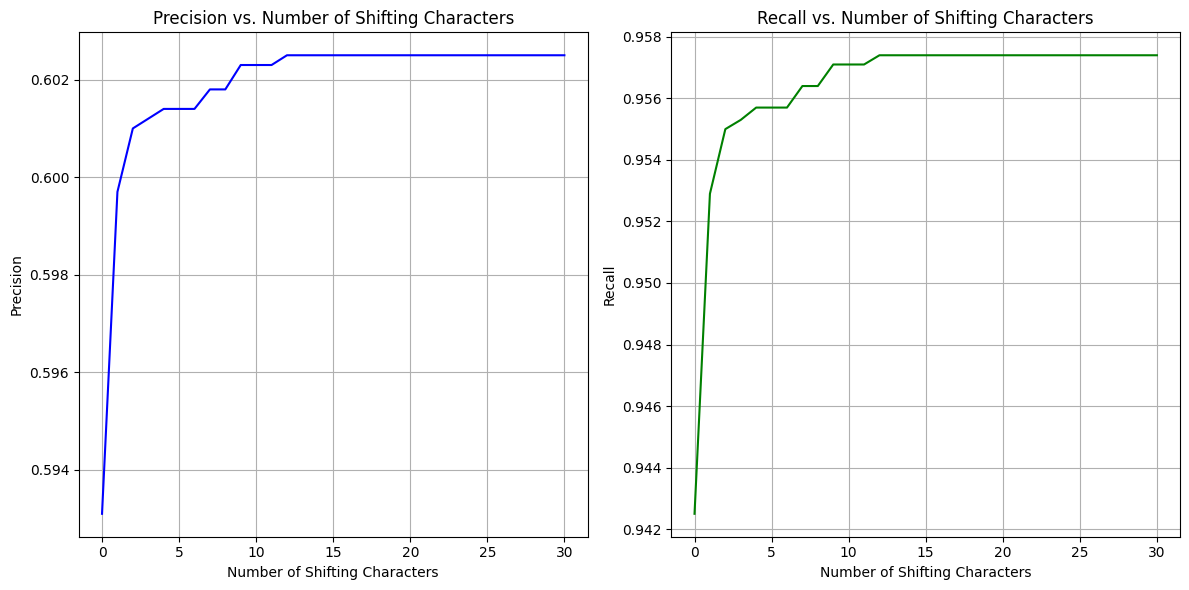

In [47]:
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_ft_detected_2.csv'
# plot_precision_recall_epsilon_together(true_file_path, detected_file_path, 60)
plot_precision_recall_epsilon_split(true_file_path, detected_file_path, 30)

In [29]:
# Fine-tune only
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_ft_detected_2.csv'

metrics_df = calculate_metrics_2(true_file_path, detected_file_path, epsilon=12)
print(f"Metrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 12): \n{metrics_df}\n")

metrics_df = calculate_metrics_2(true_file_path, detected_file_path, epsilon=100000000)
print(f"Metrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 1goal): \n{metrics_df}\n")

Metrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 12): 
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2503  1601  107     0.6099  0.9590    0.7456    0.9383
1  URL_PERSONAL   197   208   13     0.4864  0.9381    0.6407    0.9057
2         EMAIL    59    11    2     0.8429  0.9672    0.9008    0.9618
3     PHONE_NUM     7     5    1     0.5833  0.8750    0.7000    0.8585
4       Overall  2766  1825  123     0.6025  0.9574    0.7396    0.9362

Metrics DataFrame (Fine-tuned GPT-4o-mini only, epsilon = 1goal): 
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2503  1601  107     0.6099  0.9590    0.7456    0.9383
1  URL_PERSONAL   197   208   13     0.4864  0.9381    0.6407    0.9057
2         EMAIL    59    11    2     0.8429  0.9672    0.9008    0.9618
3     PHONE_NUM     7     5    1     0.5833  0.8750    0.7000    0.8585
4       Overall  2766  1825  123     0.6025  0.9574    0.7396    0.9362



In [16]:
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_pt_detected_2.csv'

metrics_df = calculate_metrics(true_file_path, detected_file_path)
print(f"Metrics DataFrame (Prompting GPT-4o-mini only, without epsilon): \n{metrics_df}\n")

metrics_df = calculate_metrics_2(true_file_path, detected_file_path)
print(f"Metrics DataFrame (Prompting GPT-4o-mini only, epsilon = 1goal): \n{metrics_df}")

Metrics DataFrame (Prompting GPT-4o-mini only, without epsilon): 
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2032   754  578     0.7294  0.7785    0.7532    0.7765
1  URL_PERSONAL   152   314   58     0.3262  0.7238    0.4497    0.6914
2         EMAIL    56    56    5     0.5000  0.9180    0.6474    0.8894
3     PHONE_NUM     4    46    4     0.0800  0.5000    0.1379    0.4160
4       Overall  2244  1170  645     0.6573  0.7767    0.7120    0.7713

Metrics DataFrame (Prompting GPT-4o-mini only, epsilon = 1goal): 
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2032   754  578     0.7294  0.7785    0.7532    0.7765
1  URL_PERSONAL   152   314   58     0.3262  0.7238    0.4497    0.6914
2         EMAIL    56    56    5     0.5000  0.9180    0.6474    0.8894
3     PHONE_NUM     4    46    4     0.0800  0.5000    0.1379    0.4160
4       Overall  2244  1170  645     0.6573  0.7767    0.7120    0.7713


In [22]:
# Prompting only
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_pt_detected_2.csv'

metrics_df_0 = calculate_metrics_2(true_file_path, detected_file_path, epsilon = 0)
metrics_df_2 = calculate_metrics_2(true_file_path, detected_file_path, epsilon = 2)
metrics_df_10 = calculate_metrics_2(true_file_path, detected_file_path, epsilon = 10)
metrics_df_1goal = calculate_metrics(true_file_path, detected_file_path)

print("Metrics DataFrame (Prompting GPT-4o-mini only, epsilon = 0):")
print(metrics_df_0)
print("\nMetrics DataFrame (Prompting GPT-4o-mini only, epsilon = 2):")
print(metrics_df_2)
print("\nMetrics DataFrame (Prompting GPT-4o-mini only, epsilon = 10):")
print(metrics_df_10)
print("\nMetrics DataFrame (Prompting GPT-4o-mini only):")
print(metrics_df_1goal)

Metrics DataFrame (Prompting GPT-4o-mini only, epsilon = 0):
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  1792   994  818     0.6432  0.6866    0.6642    0.6848
1  URL_PERSONAL   119   347   91     0.2554  0.5667    0.3521    0.5413
2         EMAIL    44    68   17     0.3929  0.7213    0.5087    0.6988
3     PHONE_NUM     4    46    4     0.0800  0.5000    0.1379    0.4160
4       Overall  1959  1455  930     0.5738  0.6781    0.6216    0.6734

Metrics DataFrame (Prompting GPT-4o-mini only, epsilon = 2):
    Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  1943   843  667     0.6974  0.7444    0.7202    0.7425
1  URL_PERSONAL   139   327   71     0.2983  0.6619    0.4112    0.6323
2         EMAIL    48    64   13     0.4286  0.7869    0.5549    0.7624
3     PHONE_NUM     4    46    4     0.0800  0.5000    0.1379    0.4160
4       Overall  2134  1280  755     0.6251  0.7387    0.6771    0.7335

Metrics Data

Processing epsilon=0
Processing epsilon=1
Processing epsilon=2
Processing epsilon=3
Processing epsilon=4
Processing epsilon=5
Processing epsilon=6
Processing epsilon=7
Processing epsilon=8
Processing epsilon=9
Processing epsilon=10
Processing epsilon=11
Processing epsilon=12
Processing epsilon=13
Processing epsilon=14
Processing epsilon=15


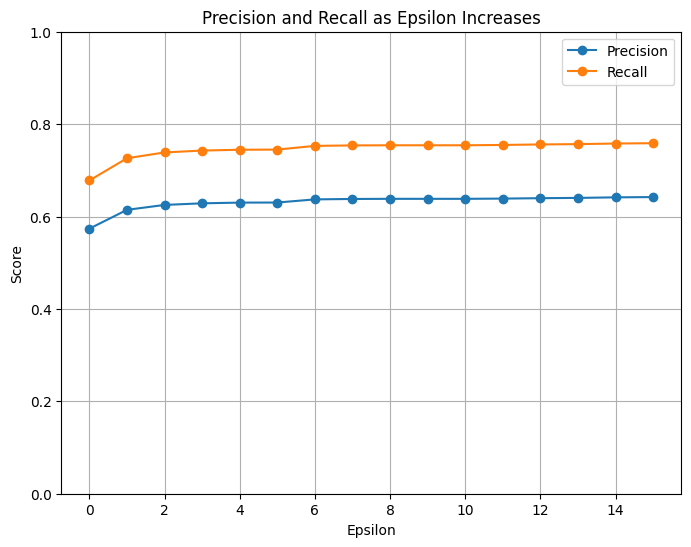

In [8]:
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_pt_detected_2.csv'
plot_precision_recall_epsilon_together(true_file_path, detected_file_path, 15)
# plot_precision_recall_epsilon_split(true_file_path, detected_file_path, 60)

Processing epsilon=0
Processing epsilon=1
Processing epsilon=2
Processing epsilon=3
Processing epsilon=4
Processing epsilon=5
Processing epsilon=6
Processing epsilon=7
Processing epsilon=8
Processing epsilon=9
Processing epsilon=10
Processing epsilon=11
Processing epsilon=12
Processing epsilon=13
Processing epsilon=14
Processing epsilon=15
Processing epsilon=16
Processing epsilon=17
Processing epsilon=18
Processing epsilon=19
Processing epsilon=20
Processing epsilon=21
Processing epsilon=22
Processing epsilon=23
Processing epsilon=24
Processing epsilon=25
Processing epsilon=26
Processing epsilon=27
Processing epsilon=28
Processing epsilon=29
Processing epsilon=30
Processing epsilon=31
Processing epsilon=32
Processing epsilon=33
Processing epsilon=34
Processing epsilon=35
Processing epsilon=36
Processing epsilon=37
Processing epsilon=38
Processing epsilon=39
Processing epsilon=40
Processing epsilon=41
Processing epsilon=42
Processing epsilon=43
Processing epsilon=44
Processing epsilon=4

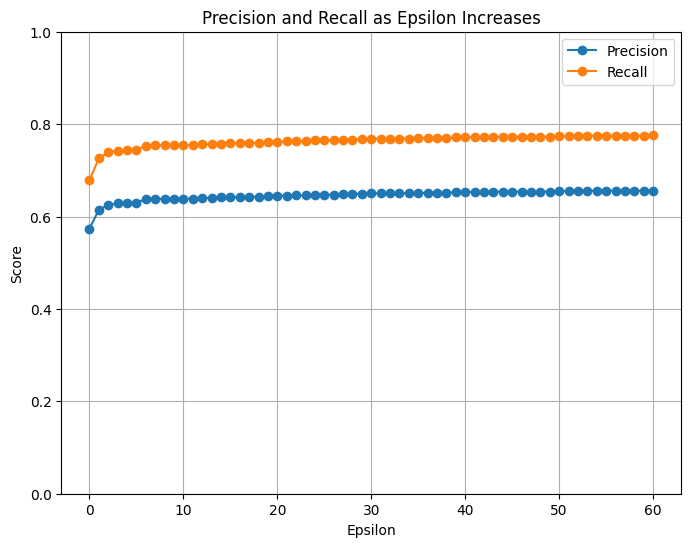

Processing epsilon=0
Processing epsilon=1
Processing epsilon=2
Processing epsilon=3
Processing epsilon=4
Processing epsilon=5
Processing epsilon=6
Processing epsilon=7
Processing epsilon=8
Processing epsilon=9
Processing epsilon=10
Processing epsilon=11
Processing epsilon=12
Processing epsilon=13
Processing epsilon=14
Processing epsilon=15
Processing epsilon=16
Processing epsilon=17
Processing epsilon=18
Processing epsilon=19
Processing epsilon=20
Processing epsilon=21
Processing epsilon=22
Processing epsilon=23
Processing epsilon=24
Processing epsilon=25
Processing epsilon=26
Processing epsilon=27
Processing epsilon=28
Processing epsilon=29
Processing epsilon=30
Processing epsilon=31
Processing epsilon=32
Processing epsilon=33
Processing epsilon=34
Processing epsilon=35
Processing epsilon=36
Processing epsilon=37
Processing epsilon=38
Processing epsilon=39
Processing epsilon=40
Processing epsilon=41
Processing epsilon=42
Processing epsilon=43
Processing epsilon=44
Processing epsilon=4

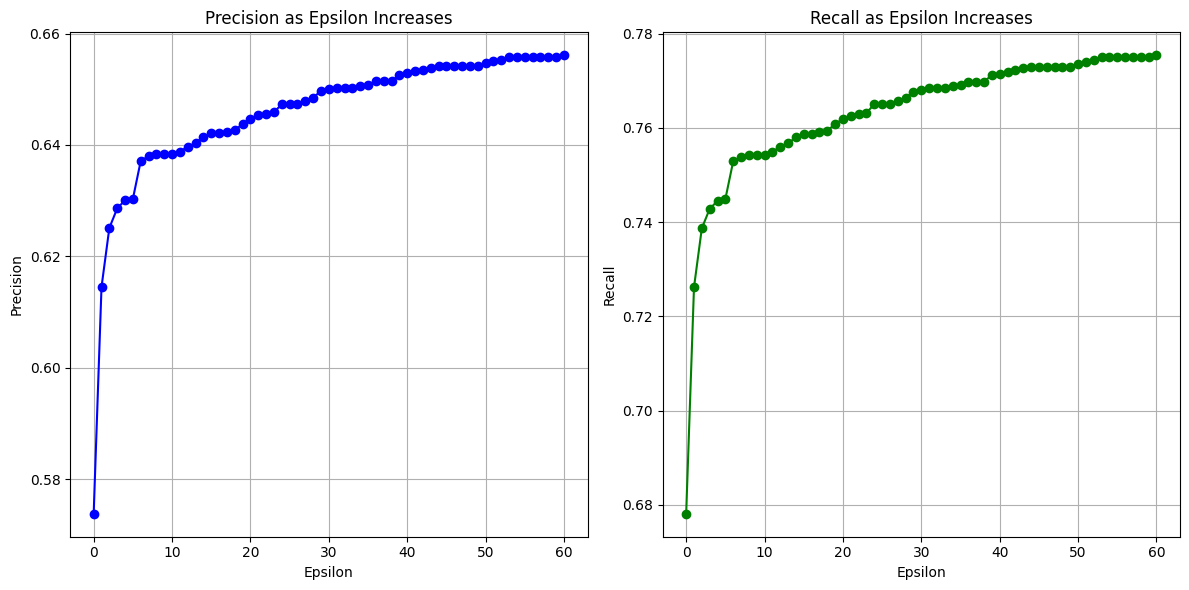

In [63]:
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_pt_detected_2.csv'
plot_precision_recall_epsilon_together(true_file_path, detected_file_path, 60)
plot_precision_recall_epsilon_split(true_file_path, detected_file_path, 60)

Processing shifting characters = 0
Processing shifting characters = 1
Processing shifting characters = 2
Processing shifting characters = 3
Processing shifting characters = 4
Processing shifting characters = 5
Processing shifting characters = 6
Processing shifting characters = 7
Processing shifting characters = 8
Processing shifting characters = 9
Processing shifting characters = 10
Processing shifting characters = 11
Processing shifting characters = 12
Processing shifting characters = 13
Processing shifting characters = 14
Processing shifting characters = 15
Processing shifting characters = 16
Processing shifting characters = 17
Processing shifting characters = 18
Processing shifting characters = 19
Processing shifting characters = 20
Processing shifting characters = 21
Processing shifting characters = 22
Processing shifting characters = 23
Processing shifting characters = 24
Processing shifting characters = 25
Processing shifting characters = 26
Processing shifting characters = 27
Pr

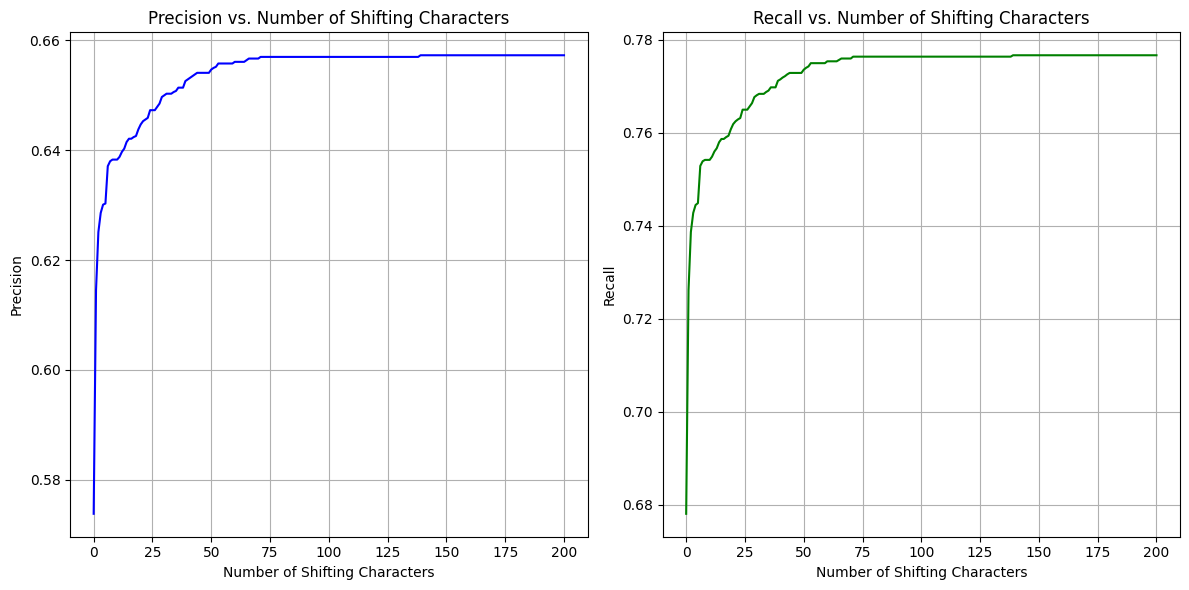

In [46]:
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_pt_detected_2.csv'
# plot_precision_recall_epsilon_together(true_file_path, detected_file_path, 60)
plot_precision_recall_epsilon_split(true_file_path, detected_file_path, 200)

In [30]:
# Prompting only
true_file_path = 'data/test_set_2.csv'
detected_file_path = 'output/pii_pt_detected_2.csv'

metrics_df = calculate_metrics_2(true_file_path, detected_file_path, epsilon = 138)
print(f"Metrics DataFrame (Prompting GPT-4o-mini only, epsilon = 138): \n {metrics_df}\n")

metrics_df = calculate_metrics_2(true_file_path, detected_file_path, epsilon = 139)
print(f"Metrics DataFrame (Prompting GPT-4o-mini only, epsilon = 139): \n {metrics_df}\n")

metrics_df = calculate_metrics_2(true_file_path, detected_file_path, epsilon = 100000000)
print(f"Metrics DataFrame (Prompting GPT-4o-mini only, epsilon = 1goal): \n {metrics_df}\n")

Metrics DataFrame (Prompting GPT-4o-mini only, epsilon = 138): 
     Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2031   755  579     0.7290  0.7782    0.7528    0.7761
1  URL_PERSONAL   152   314   58     0.3262  0.7238    0.4497    0.6914
2         EMAIL    56    56    5     0.5000  0.9180    0.6474    0.8894
3     PHONE_NUM     4    46    4     0.0800  0.5000    0.1379    0.4160
4       Overall  2243  1171  646     0.6570  0.7764    0.7117    0.7710

Metrics DataFrame (Prompting GPT-4o-mini only, epsilon = 139): 
     Entity Type    TP    FP   FN  Precision  Recall  F1 Score  F5 Score
0  NAME_STUDENT  2032   754  578     0.7294  0.7785    0.7532    0.7765
1  URL_PERSONAL   152   314   58     0.3262  0.7238    0.4497    0.6914
2         EMAIL    56    56    5     0.5000  0.9180    0.6474    0.8894
3     PHONE_NUM     4    46    4     0.0800  0.5000    0.1379    0.4160
4       Overall  2244  1170  645     0.6573  0.7767    0.7120    0.7713

Metr

Processing shifting characters = 0 for file: output/pii_pt_detected_2.csv
Processing shifting characters = 1 for file: output/pii_pt_detected_2.csv
Processing shifting characters = 2 for file: output/pii_pt_detected_2.csv
Processing shifting characters = 3 for file: output/pii_pt_detected_2.csv
Processing shifting characters = 4 for file: output/pii_pt_detected_2.csv
Processing shifting characters = 5 for file: output/pii_pt_detected_2.csv
Processing shifting characters = 6 for file: output/pii_pt_detected_2.csv
Processing shifting characters = 7 for file: output/pii_pt_detected_2.csv
Processing shifting characters = 8 for file: output/pii_pt_detected_2.csv
Processing shifting characters = 9 for file: output/pii_pt_detected_2.csv
Processing shifting characters = 10 for file: output/pii_pt_detected_2.csv
Processing shifting characters = 11 for file: output/pii_pt_detected_2.csv
Processing shifting characters = 12 for file: output/pii_pt_detected_2.csv
Processing shifting characters = 13

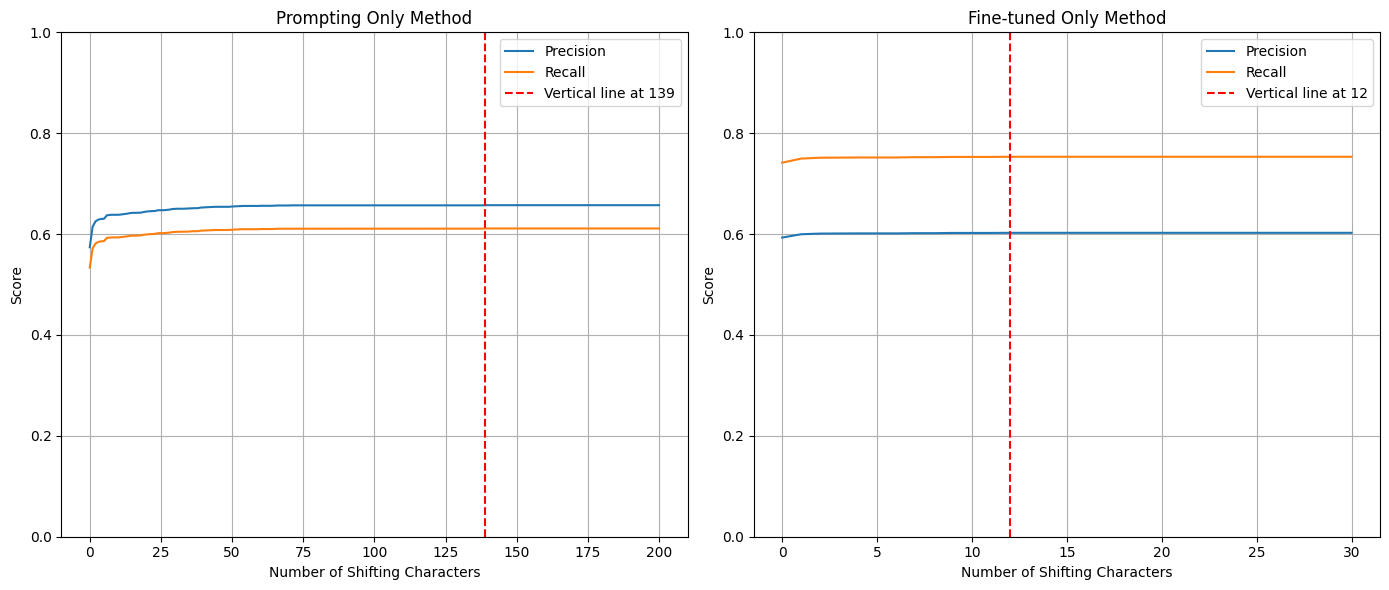

In [54]:
# Usage Example
true_file_path = 'data/test_set.csv'
detected_file_path_lst = ['output/pii_pt_detected_2.csv', 'output/pii_ft_detected_2.csv']

# Call the function to plot for epsilon values
plot_precision_recall_epsilon_split_methods(true_file_path, detected_file_path_lst)